In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
                        

In [6]:
N = 400
series = np.sin((0.1*(np.arange(N)-200))**2)


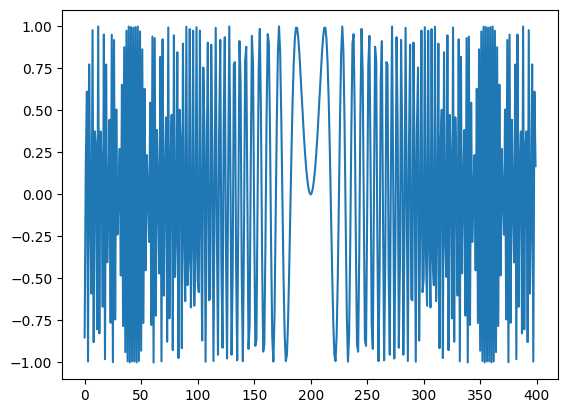

In [7]:
plt.plot(series)
plt.show()

In [17]:
### build the dataset
# let's see if we can use T past values to predict the next value
T = 10
X = []
Y = []
for t in range(len(series) - T):
  x = series[t:t+T]
  X.append(x)
  y = series[t+T]
  Y.append(y)

X = np.array(X).reshape(-1, T, 1)
Y = np.array(Y).reshape(-1, 1)
N = len(X)
print("X.shape", X.shape, "Y.shape", Y.shape)

X.shape (390, 10, 1) Y.shape (390, 1)


In [18]:
X.shape, Y.shape

((390, 10, 1), (390, 1))

In [19]:
N = len(X)
print("X shape", X.shape, "Y shape", Y.shape)

X shape (390, 10, 1) Y shape (390, 1)


In [20]:


# Set device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)




cpu


In [29]:
### Define simple RNN
class SimpleRNN(nn.Module):
  def __init__(self, n_inputs, n_hidden, n_rnnlayers, n_outputs):
    super(SimpleRNN, self).__init__()
    self.D = n_inputs
    self.M = n_hidden
    self.K = n_outputs
    self.L = n_rnnlayers

    # note: batch_first=True
    # applies the convention that our data will be of shape:
    # (num_samples, sequence_length, num_features)
    # rather than:
    # (sequence_length, num_samples, num_features)
    self.rnn = nn.LSTM(
        input_size=self.D,
        hidden_size=self.M,
        num_layers=self.L,
        batch_first=True)
    self.fc = nn.Linear(self.M, self.K)
  
  def forward(self, X):
    # initial hidden states
    h0 = torch.zeros(self.L, X.size(0), self.M).to(device)
    c0 = torch.zeros(self.L, X.size(0), self.M).to(device)

    # get RNN unit output
    # out is of size (N, T, M)
    # 2nd return value is hidden states at each hidden layer
    # we don't need those now
    out, _ = self.rnn(X, (h0,c0))

    # we only want h(T) at the final time step
    # N x M -> N x K
    out = self.fc(out[:, -1, :])
    return out



In [30]:


# Instantiate the model
model = SimpleRNN(n_inputs=1, n_hidden=15, n_rnnlayers=1, n_outputs=1)
model.to(device)


criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
model

SimpleRNN(
  (rnn): LSTM(1, 15, batch_first=True)
  (fc): Linear(in_features=15, out_features=1, bias=True)
)

In [31]:
X_train = torch.from_numpy(X[:-N//2].astype(np.float32))
y_train = torch.from_numpy(Y[:-N//2].astype(np.float32))
X_test = torch.from_numpy(X[-N//2:].astype(np.float32))
y_test = torch.from_numpy(Y[-N//2:].astype(np.float32))


In [32]:


# move data to GPU
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)



In [33]:
def full_gd(model,
            criterion,
            optimizer,
            X_train,
            y_train,
            X_test,
            y_test, 
            epochs=1000):
    train_losses = np.zeros(epochs)
    test_losses = np.zeros(epochs)

    for it in range(epochs):
        optimizer.zero_grad()
        outputs = model(X_train)
        loss = criterion(outputs, y_train)
        
        loss.backward()
        optimizer.step()

        train_losses[it] = loss.item()
        test_outputs = model(X_test)
        test_loss = criterion(test_outputs, y_test)
        test_losses[it] = test_loss.item()

        print(f"Epoch {it}/{epochs} train loss: {train_losses[it]} test_losses: {test_loss}")
    return train_losses, test_losses

In [34]:
train_losses, test_losses = full_gd(model,
                                    criterion,
                                    optimizer,
                                    X_train,
                                    y_train,
                                    X_test,
                                    y_test)

Epoch 0/1000 train loss: 0.565468430519104 test_losses: 0.5827736258506775
Epoch 1/1000 train loss: 0.5623259544372559 test_losses: 0.579746425151825
Epoch 2/1000 train loss: 0.5592954754829407 test_losses: 0.5768278241157532
Epoch 3/1000 train loss: 0.5563737154006958 test_losses: 0.574012279510498
Epoch 4/1000 train loss: 0.5535551309585571 test_losses: 0.5712928771972656
Epoch 5/1000 train loss: 0.5508326888084412 test_losses: 0.5686622262001038
Epoch 6/1000 train loss: 0.5481990575790405 test_losses: 0.5661133527755737
Epoch 7/1000 train loss: 0.545647144317627 test_losses: 0.563640296459198
Epoch 8/1000 train loss: 0.5431712865829468 test_losses: 0.5612383484840393
Epoch 9/1000 train loss: 0.5407662987709045 test_losses: 0.558903694152832
Epoch 10/1000 train loss: 0.5384286046028137 test_losses: 0.5566334128379822
Epoch 11/1000 train loss: 0.5361555218696594 test_losses: 0.5544255375862122
Epoch 12/1000 train loss: 0.5339449048042297 test_losses: 0.5522788166999817
Epoch 13/1000 t

[]

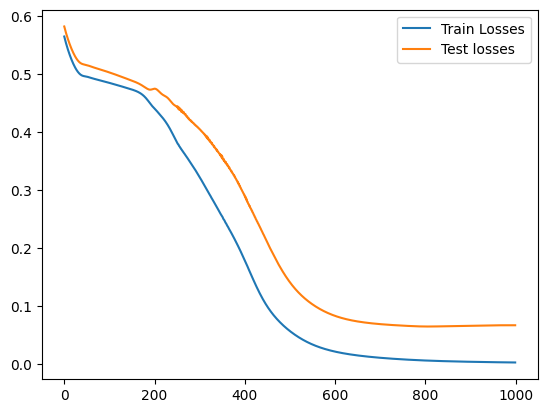

In [35]:
plt.plot(train_losses, label="Train Losses")
plt.plot(test_losses, label="Test losses")
plt.legend()
plt.plot()

In [36]:
# Wrong way to do it

validation_target = Y[-N//2:]
validation_predictions = []

i = 0
while len(validation_predictions) < len(validation_target):
    input_ = X_test[i].view(1, -1, 1)
    p = model(input_)[0,0].item() # 1x1 array a escalar
    i += 1

    validation_predictions.append(p)



[]

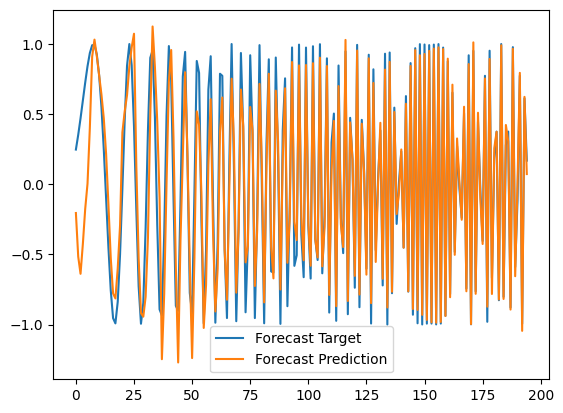

In [37]:
plt.plot(validation_target, label="Forecast Target")
plt.plot(validation_predictions, label="Forecast Prediction")
plt.legend()
plt.plot()

In [38]:

validation_target = Y[-N//2:]
validation_predictions = []

i = 0

x_ =X_test[0].view(T)

while len(validation_predictions) < len(validation_target):
    input_ = x_.reshape(1, T , 1)
    p = model(input_) # 1x1 array a escalar
    i += 1

    validation_predictions.append(p[0,0].item())
    print(p[0])
    print(x_[1:])
    x_ = torch.cat((x_[1:], p[0]))


tensor([-0.2049], grad_fn=<SelectBackward0>)
tensor([0.1593, 0.0899, 0.0400, 0.0100, 0.0000, 0.0100, 0.0400, 0.0899, 0.1593])
tensor([0.0212], grad_fn=<SelectBackward0>)
tensor([ 0.0899,  0.0400,  0.0100,  0.0000,  0.0100,  0.0400,  0.0899,  0.1593,
        -0.2049], grad_fn=<SliceBackward0>)
tensor([-0.0009], grad_fn=<SelectBackward0>)
tensor([ 0.0400,  0.0100,  0.0000,  0.0100,  0.0400,  0.0899,  0.1593, -0.2049,
         0.0212], grad_fn=<SliceBackward0>)
tensor([-0.2409], grad_fn=<SelectBackward0>)
tensor([ 0.0100,  0.0000,  0.0100,  0.0400,  0.0899,  0.1593, -0.2049,  0.0212,
        -0.0009], grad_fn=<SliceBackward0>)
tensor([0.1710], grad_fn=<SelectBackward0>)
tensor([ 0.0000,  0.0100,  0.0400,  0.0899,  0.1593, -0.2049,  0.0212, -0.0009,
        -0.2409], grad_fn=<SliceBackward0>)
tensor([-0.1786], grad_fn=<SelectBackward0>)
tensor([ 0.0100,  0.0400,  0.0899,  0.1593, -0.2049,  0.0212, -0.0009, -0.2409,
         0.1710], grad_fn=<SliceBackward0>)
tensor([-0.0250], grad_fn=<Sele

[]

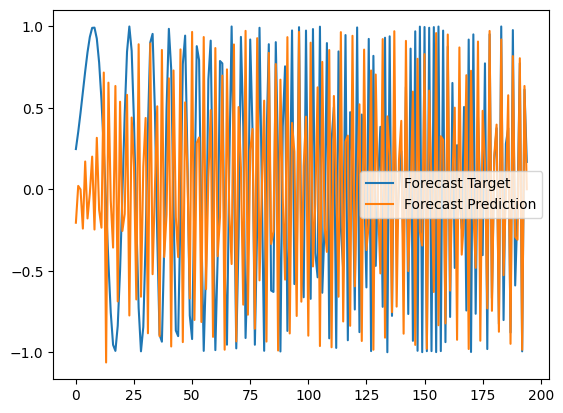

In [39]:
plt.plot(validation_target, label="Forecast Target")
plt.plot(validation_predictions, label="Forecast Prediction")
plt.legend()
plt.plot()